In [4]:
import os

imdb_dir = '/home/ubuntu/datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)

    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()

            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
len(texts)

25000

In [4]:
len(labels)

25000

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 只保留前100个单词的评论
training_samples = 200  # 在200个样本上训练
validation_samples = 10000  # 对10000个样品进行验证
max_words = 10000  # 只考虑数据集中最常见的10000 个单词

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# 将数据划分为训练集和验证集
# 首先打乱数据, 因为一开始数据集是排好序的
# 负面评论在前, 正面评论在后
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [7]:
glove_dir = '/home/ubuntu/datasets/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
for key,value in embeddings_index.items():
    print(key,value)
    print(value.shape)
    break

the [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.270

In [9]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 在嵌入索引(embedding index)找不到的词，其嵌入向量都设为0
            embedding_matrix[i] = embedding_vector

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


2023-09-10 00:27:39.240032: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [12]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 4s 482ms/step - loss: 1.5978 - acc: 0.4900 - val_loss: 0.7411 - val_acc: 0.5062
Epoch 2/10
7/7 [==============================] - 2s 343ms/step - loss: 0.5386 - acc: 0.7350 - val_loss: 0.9079 - val_acc: 0.5055
Epoch 3/10
7/7 [==============================] - 2s 379ms/step - loss: 0.3881 - acc: 0.8550 - val_loss: 0.8212 - val_acc: 0.5113
Epoch 4/10
7/7 [==============================] - 2s 406ms/step - loss: 0.3911 - acc: 0.7800 - val_loss: 0.6991 - val_acc: 0.5500
Epoch 5/10
7/7 [==============================] - 2s 271ms/step - loss: 0.2854 - acc: 0.9100 - val_loss: 0.6883 - val_acc: 0.5687
Epoch 6/10
7/7 [==============================] - 3s 452ms/step - loss: 0.1174 - acc: 1.0000 - val_loss: 0.7393 - val_acc: 0.5606
Epoch 7/10
7/7 [==============================] - 5s 865ms/step - loss: 0.2389 - acc: 0.9050 - val_loss: 0.7340 - val_acc: 0.5686
Epoch 8/10
7/7 [==============================] - 2s 259ms/step - loss: 0.0494 - acc: 1.00

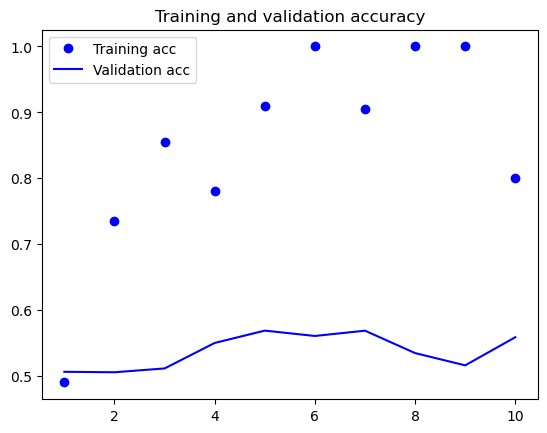

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()